In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

pd.set_option('display.max_colwidth', None)

In [2]:
## from topspin txt file to two column txt file
def dataconv(mdir, filename, ppm_max, ppm_min, outname):
    data = pd.read_csv(os.path.join(mdir, filename), header = None, skiprows = 10)
    data['ppm'] = np.linspace(ppm_max, ppm_min, data.shape[0])
    data.columns = ['intensity', 'ppm']
    data[['ppm', 'intensity']].to_csv(os.path.join(mdir, outname), index = False) 

In [3]:
## directory where data are stored
mdir = r'C:\Users\as836\Documents\SignalScienceLab\SciAdv_NMR_Shift_vf\Data'

## Data conversion

In [ ]:
## conversion of glutathione data, divided into two regions
dataconv(mdir, 'glutathione.txt', 9.5065, -0.5079, 'glutathione_conv.txt')

## conversion of cellobiose, fructose, and sucrose data
dataconv(mdir, 'cellobiose.txt', 6.0022, 0.4983, 'cellobiose_conv.txt')
dataconv(mdir, 'fructose.txt', 6.0022, 0.4983, 'fructose_conv.txt')
dataconv(mdir, 'sucrose.txt', 5.9998, 0.4981, 'sucrose_conv.txt')

## conversion of amino acid data
dataconv(mdir, 'glutamine_600MHz.txt', 3.99362, 1.89407, 'glutamine_conv.txt')
dataconv(mdir, 'glycine_500MHz.txt', 3.99984, 2.49798, 'glycine_conv.txt')
dataconv(mdir, 'isoleucine_600MHz.txt', 5.99704, 0.26910, 'isoleucine_conv.txt')
dataconv(mdir, 'leucine_500MHz.txt', 5.99975, 0.49806, 'leucine_conv.txt')
dataconv(mdir, 'threonine_500MHz.txt', 4.50342, 0.26829, 'threonine_conv.txt')
dataconv(mdir, 'valine_500MHz.txt', 4.00750, 0.49806, 'valine_conv.txt')

## Creating mixed NMR spectra for cellobiose, fructose and sucrose

In [4]:
## read cellobiose, fructose and sucrose data
cell_data = pd.read_csv(os.path.join(mdir,'cellobiose_conv.txt'), sep = ',')
cell_data.intensity /= cell_data.intensity.sum()

fruc_data = pd.read_csv(os.path.join(mdir,'fructose_conv.txt'), sep = ',')
fruc_data.intensity /= fruc_data.intensity.sum()

scrs_data = pd.read_csv(os.path.join(mdir,'sucrose_conv.txt'), sep = ',')
scrs_data.intensity /= scrs_data.intensity.sum()

## create mixed datasets
ndat1 = cell_data.merge(fruc_data, on = 'ppm', how = 'outer')
ndat1['intensity'] = ndat1.iloc[:,1:].sum(axis = 1)
ndat1 = ndat1[['ppm', 'intensity']]
ndat1 = ndat1.merge(scrs_data, on = 'ppm', how = 'outer')
ndat1['intensity'] = ndat1.iloc[:,1:].sum(axis = 1)
ndat1 = ndat1.fillna(0)
ndat1 = ndat1.groupby('ppm').sum().reset_index()

## make it consistent with the resolution of the data
#_len = int((fruc_data.shape[0] + gluc_data.shape[0] + scrs_data.shape[0])/3)
_len = int((cell_data.shape[0]+fruc_data.shape[0]+scrs_data.shape[0])/3)
ndat1['labels'] = pd.cut(ndat1.ppm, _len, labels = False)
ndat1 = ndat1.groupby(by = 'labels').mean().reset_index(drop = True)

## add noise
ndat1_noisy = ndat1.loc[:, ['ppm', 'intensity']]
_noise = (np.random.random(ndat1.shape[0]) - 0.5)*0.025*ndat1.intensity.max()
ndat1_noisy.intensity += _noise

## save data
ndat1[['ppm', 'intensity']].to_csv('cfs_mix0_vf.txt', index = False)
ndat1_noisy.to_csv('cfs_mix0_noisy_vf.txt', index = False)

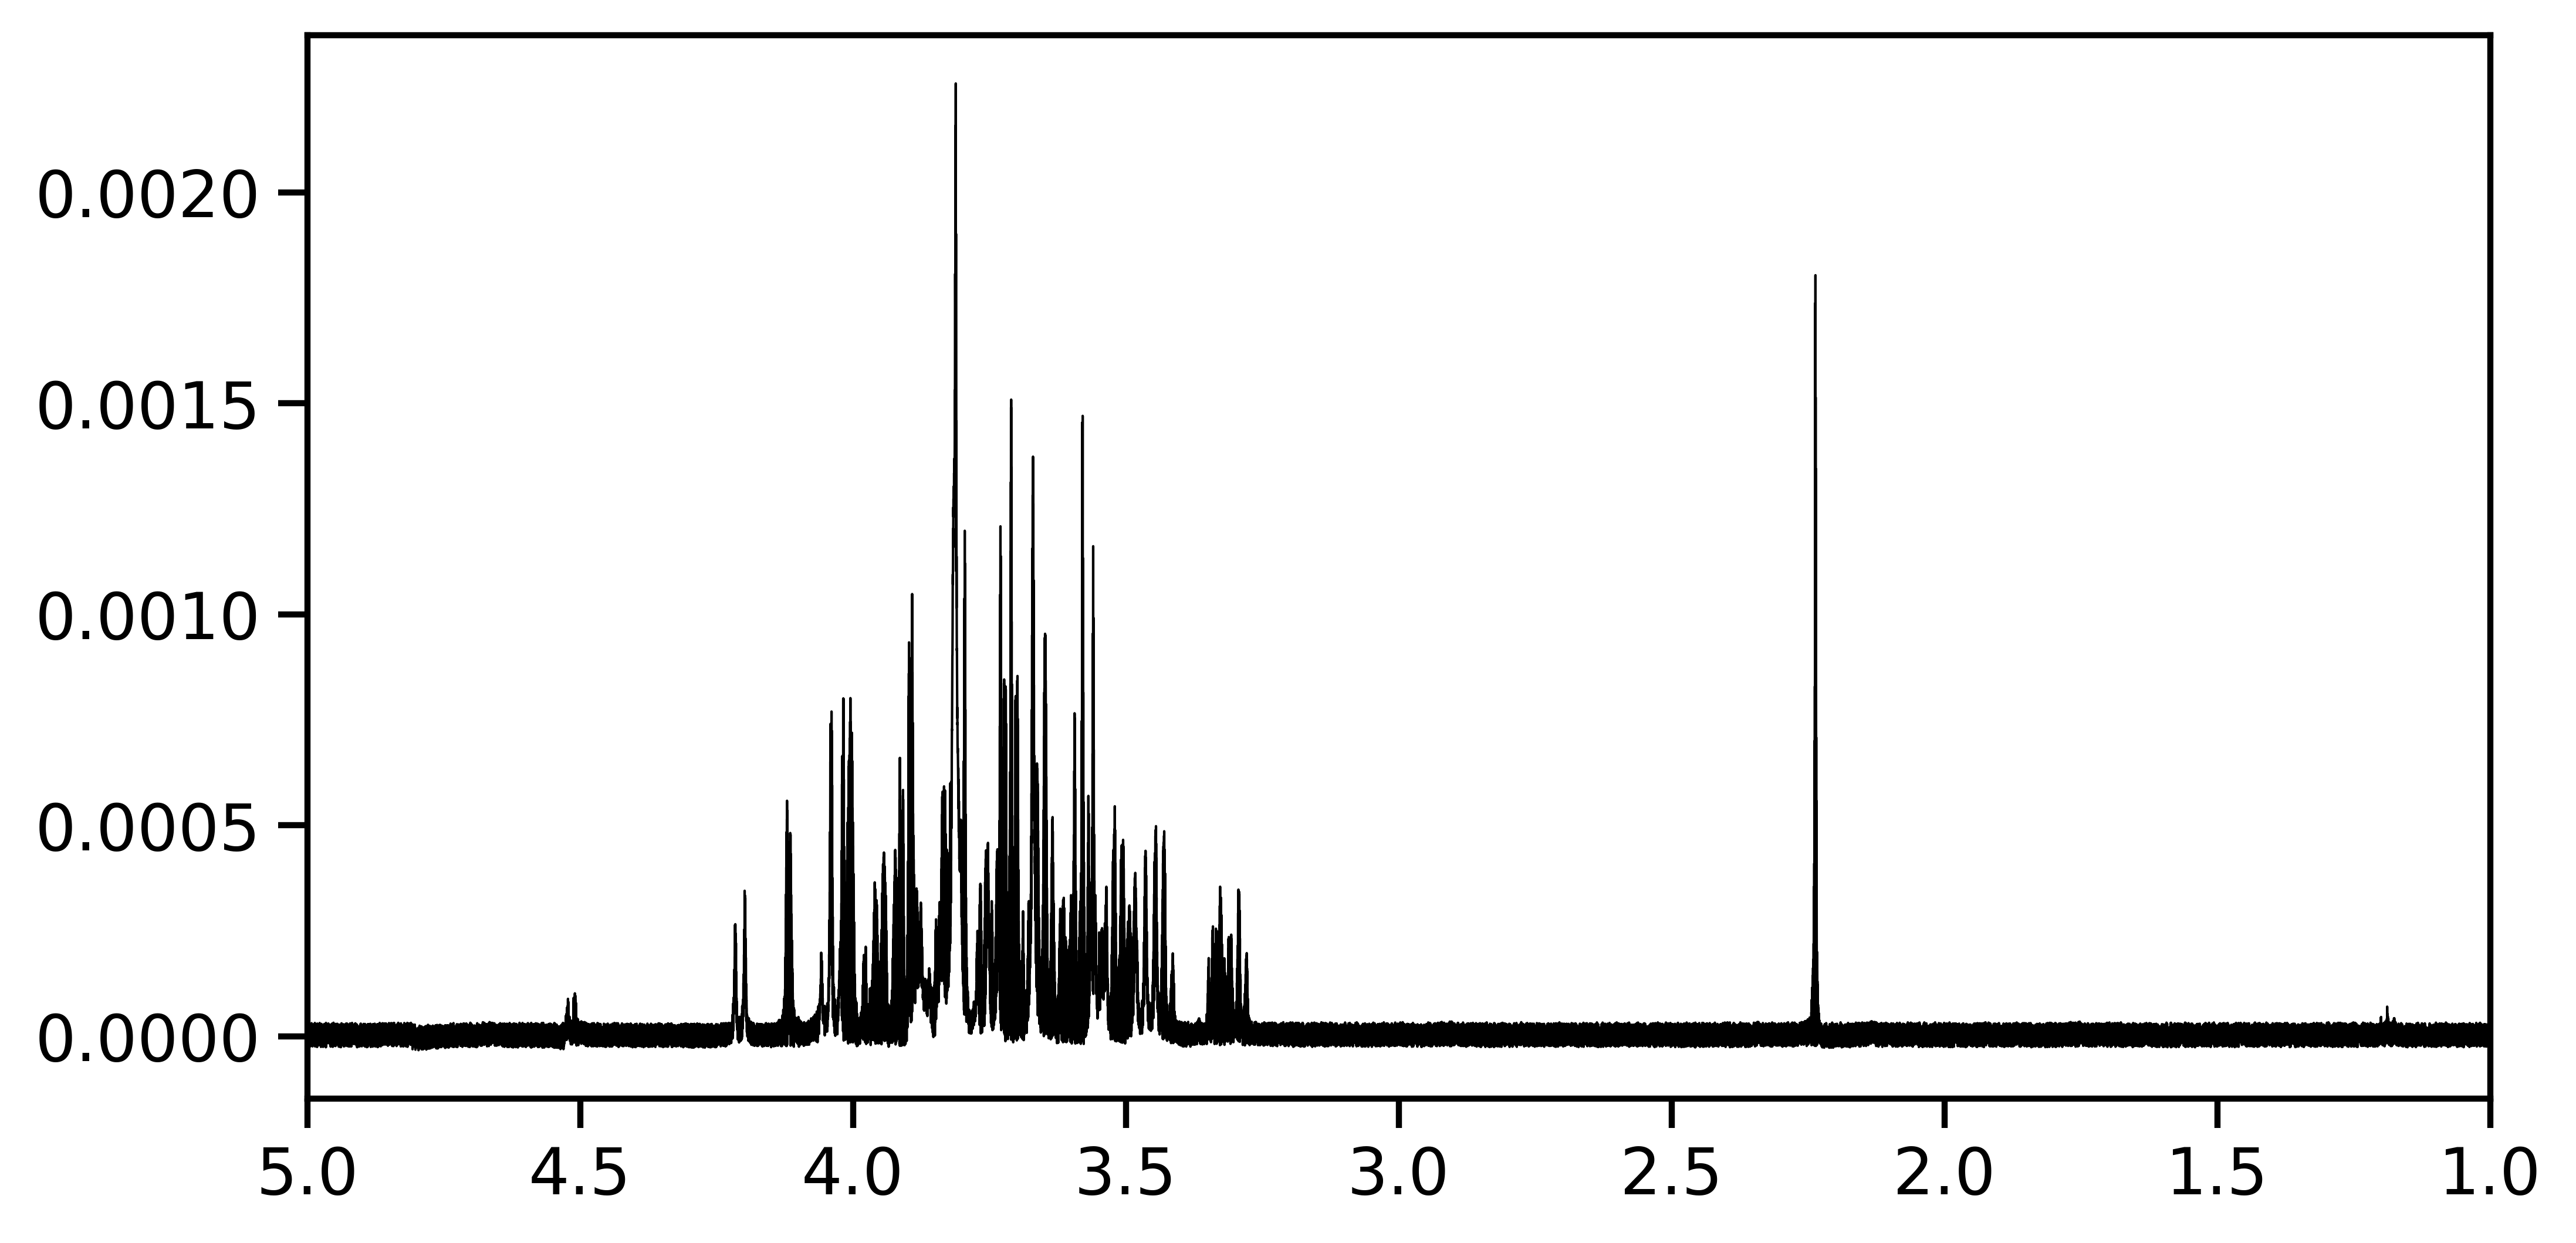

In [5]:
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.1})
fig = plt.figure(figsize = (8, 4), dpi = 600) # change dpi to 1200
plt.plot(ndat1.ppm, ndat1_noisy.intensity, color = 'black', linewidth = 0.5)
plt.xlim([5.0, 1.0])
plt.show()

## Creating mixed NMR spectra for amino acids

In [6]:
## read individual nmr data
glu_data = pd.read_csv(os.path.join(mdir,'glutamine_conv.txt'), sep = ',')
glu_data.intensity /= glu_data.intensity.sum()

gly_data = pd.read_csv(os.path.join(mdir,'glycine_conv.txt'), sep = ',')
gly_data.intensity /= gly_data.intensity.sum()

ile_data = pd.read_csv(os.path.join(mdir,'isoleucine_conv.txt'), sep = ',')
ile_data.intensity /= ile_data.intensity.sum()

leu_data = pd.read_csv(os.path.join(mdir,'leucine_conv.txt'), sep = ',')
leu_data.intensity /= leu_data.intensity.sum()

thr_data = pd.read_csv(os.path.join(mdir,'threonine_conv.txt'), sep = ',')
thr_data.intensity /= thr_data.intensity.sum()

val_data = pd.read_csv(os.path.join(mdir,'valine_conv.txt'), sep = ',')
val_data.intensity /= val_data.intensity.sum()

## create mixed datasets
dat_files = [gly_data, ile_data, leu_data, thr_data, val_data]
datm = glu_data
for dats in dat_files:
    ndat = datm.merge(dats, on = 'ppm', how = 'outer')
    ndat = ndat.fillna(0)
    ndat['intensity'] = ndat.iloc[:,1:].sum(axis = 1)
    datm = ndat[['ppm', 'intensity']]

datm = datm.groupby('ppm').sum().reset_index()

## make it consistent with the resolution of the data
_len = int((glu_data.shape[0] + gly_data.shape[0] + ile_data.shape[0] 
            + leu_data.shape[0] + thr_data.shape[0] + val_data.shape[0])/6)
datm['labels'] = pd.cut(datm.ppm, _len, labels = False)
datm = datm.groupby(by = 'labels').mean().reset_index(drop = True)

## add noise
datm_noisy = datm.loc[:, ['ppm', 'intensity']]
_noise = (np.random.random(datm.shape[0]) - 0.5)*datm.intensity.max()*0.02
datm_noisy.intensity += _noise

## save data
datm[['ppm', 'intensity']].to_csv('metabol_mix_vf.txt', index = False)
datm_noisy.to_csv('metabol_mix_noisy_vf.txt', index = False)

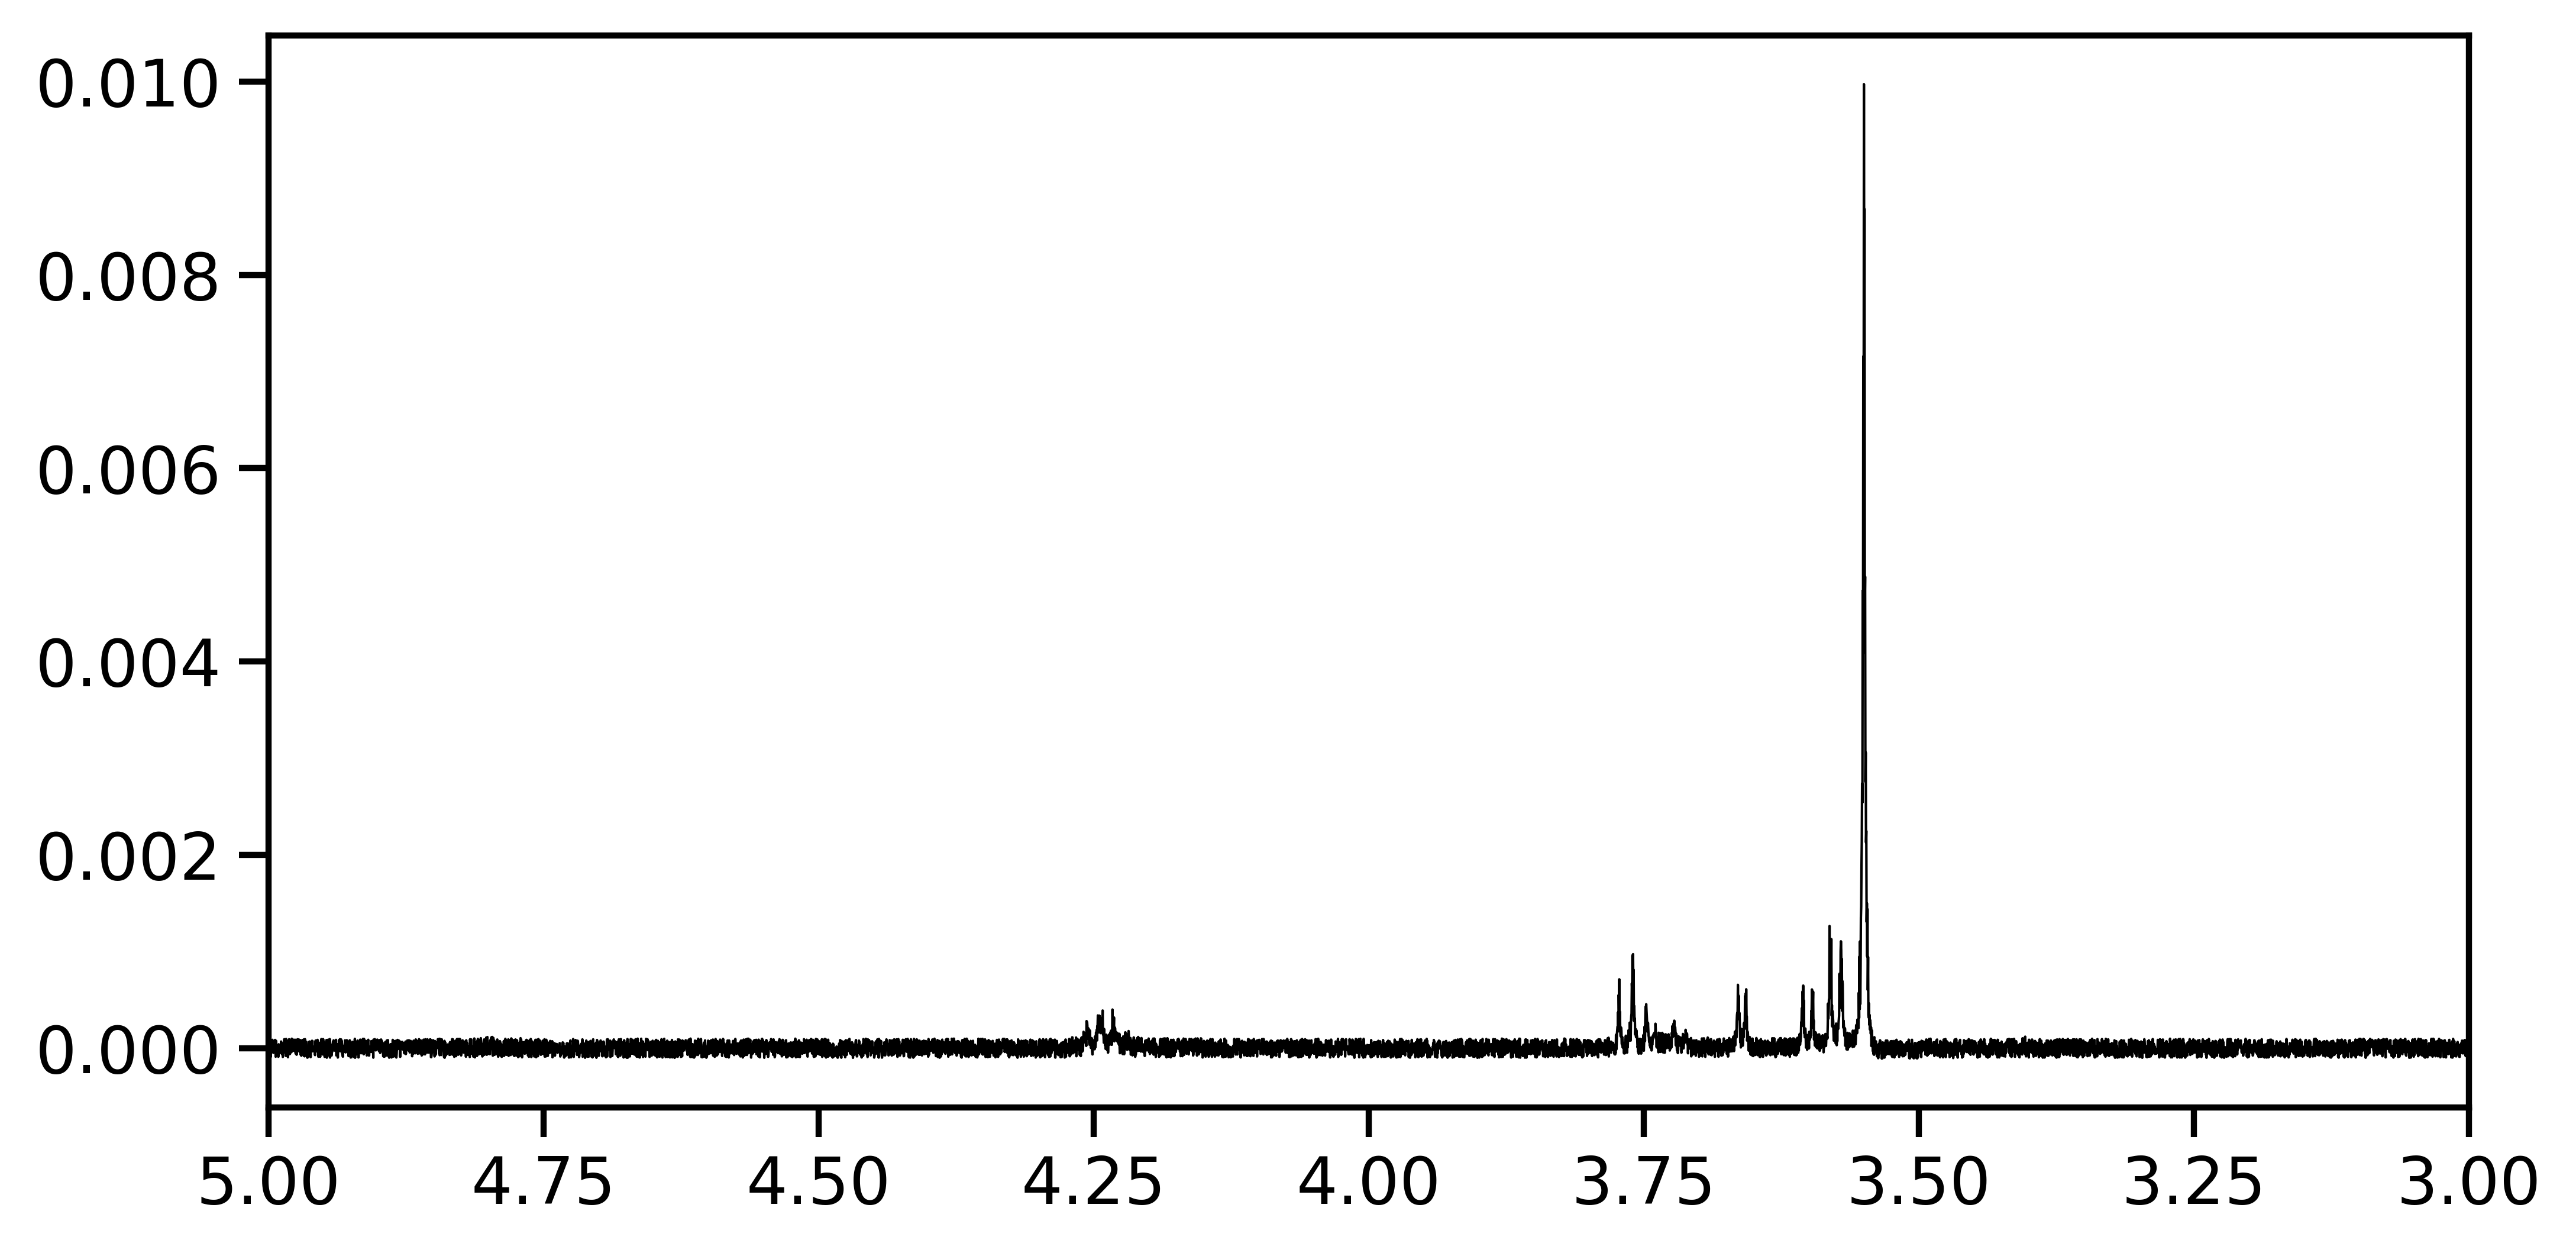

In [7]:
fig = plt.figure(figsize = (8, 4), dpi = 600) # change dpi to 1200
plt.plot(datm.ppm, datm_noisy.intensity, color = 'black', linewidth = 0.5)
plt.xlim([5.0, 3.0])
plt.show()

In [8]:
## create second mixed datasets
dat_files = [gly_data, ile_data, leu_data, thr_data, val_data]
props = [0.1, 0.15, 0.15, 0.3, 0.1]
datm = glu_data
datm.intensity *= 0.2
for j in range(5):
    dats = dat_files[j]
    dats.intensity *= props[j]
    ndat = datm.merge(dats, on = 'ppm', how = 'outer')
    ndat = ndat.fillna(0)
    ndat['intensity'] = ndat.iloc[:,1:].sum(axis = 1)
    datm = ndat[['ppm', 'intensity']]

datm = datm.groupby('ppm').sum().reset_index()
datm.intensity /= datm.intensity.sum()

## make it consistent with the resolution of the data
_len = int((glu_data.shape[0] + gly_data.shape[0] + ile_data.shape[0] 
            + leu_data.shape[0] + thr_data.shape[0] + val_data.shape[0])/6)
datm['labels'] = pd.cut(datm.ppm, _len, labels = False)
datm = datm.groupby(by = 'labels').mean().reset_index(drop = True)

## add noise
datm_noisy = datm.loc[:, ['ppm', 'intensity']]
_noise = (np.random.random(datm.shape[0]) - 0.5)*datm.intensity.max()*0.02
datm_noisy.intensity += _noise

## save data
datm[['ppm', 'intensity']].to_csv('metabol_mix2_vf.txt', index = False)
datm_noisy.to_csv('metabol_mix2_noisy_vf.txt', index = False)

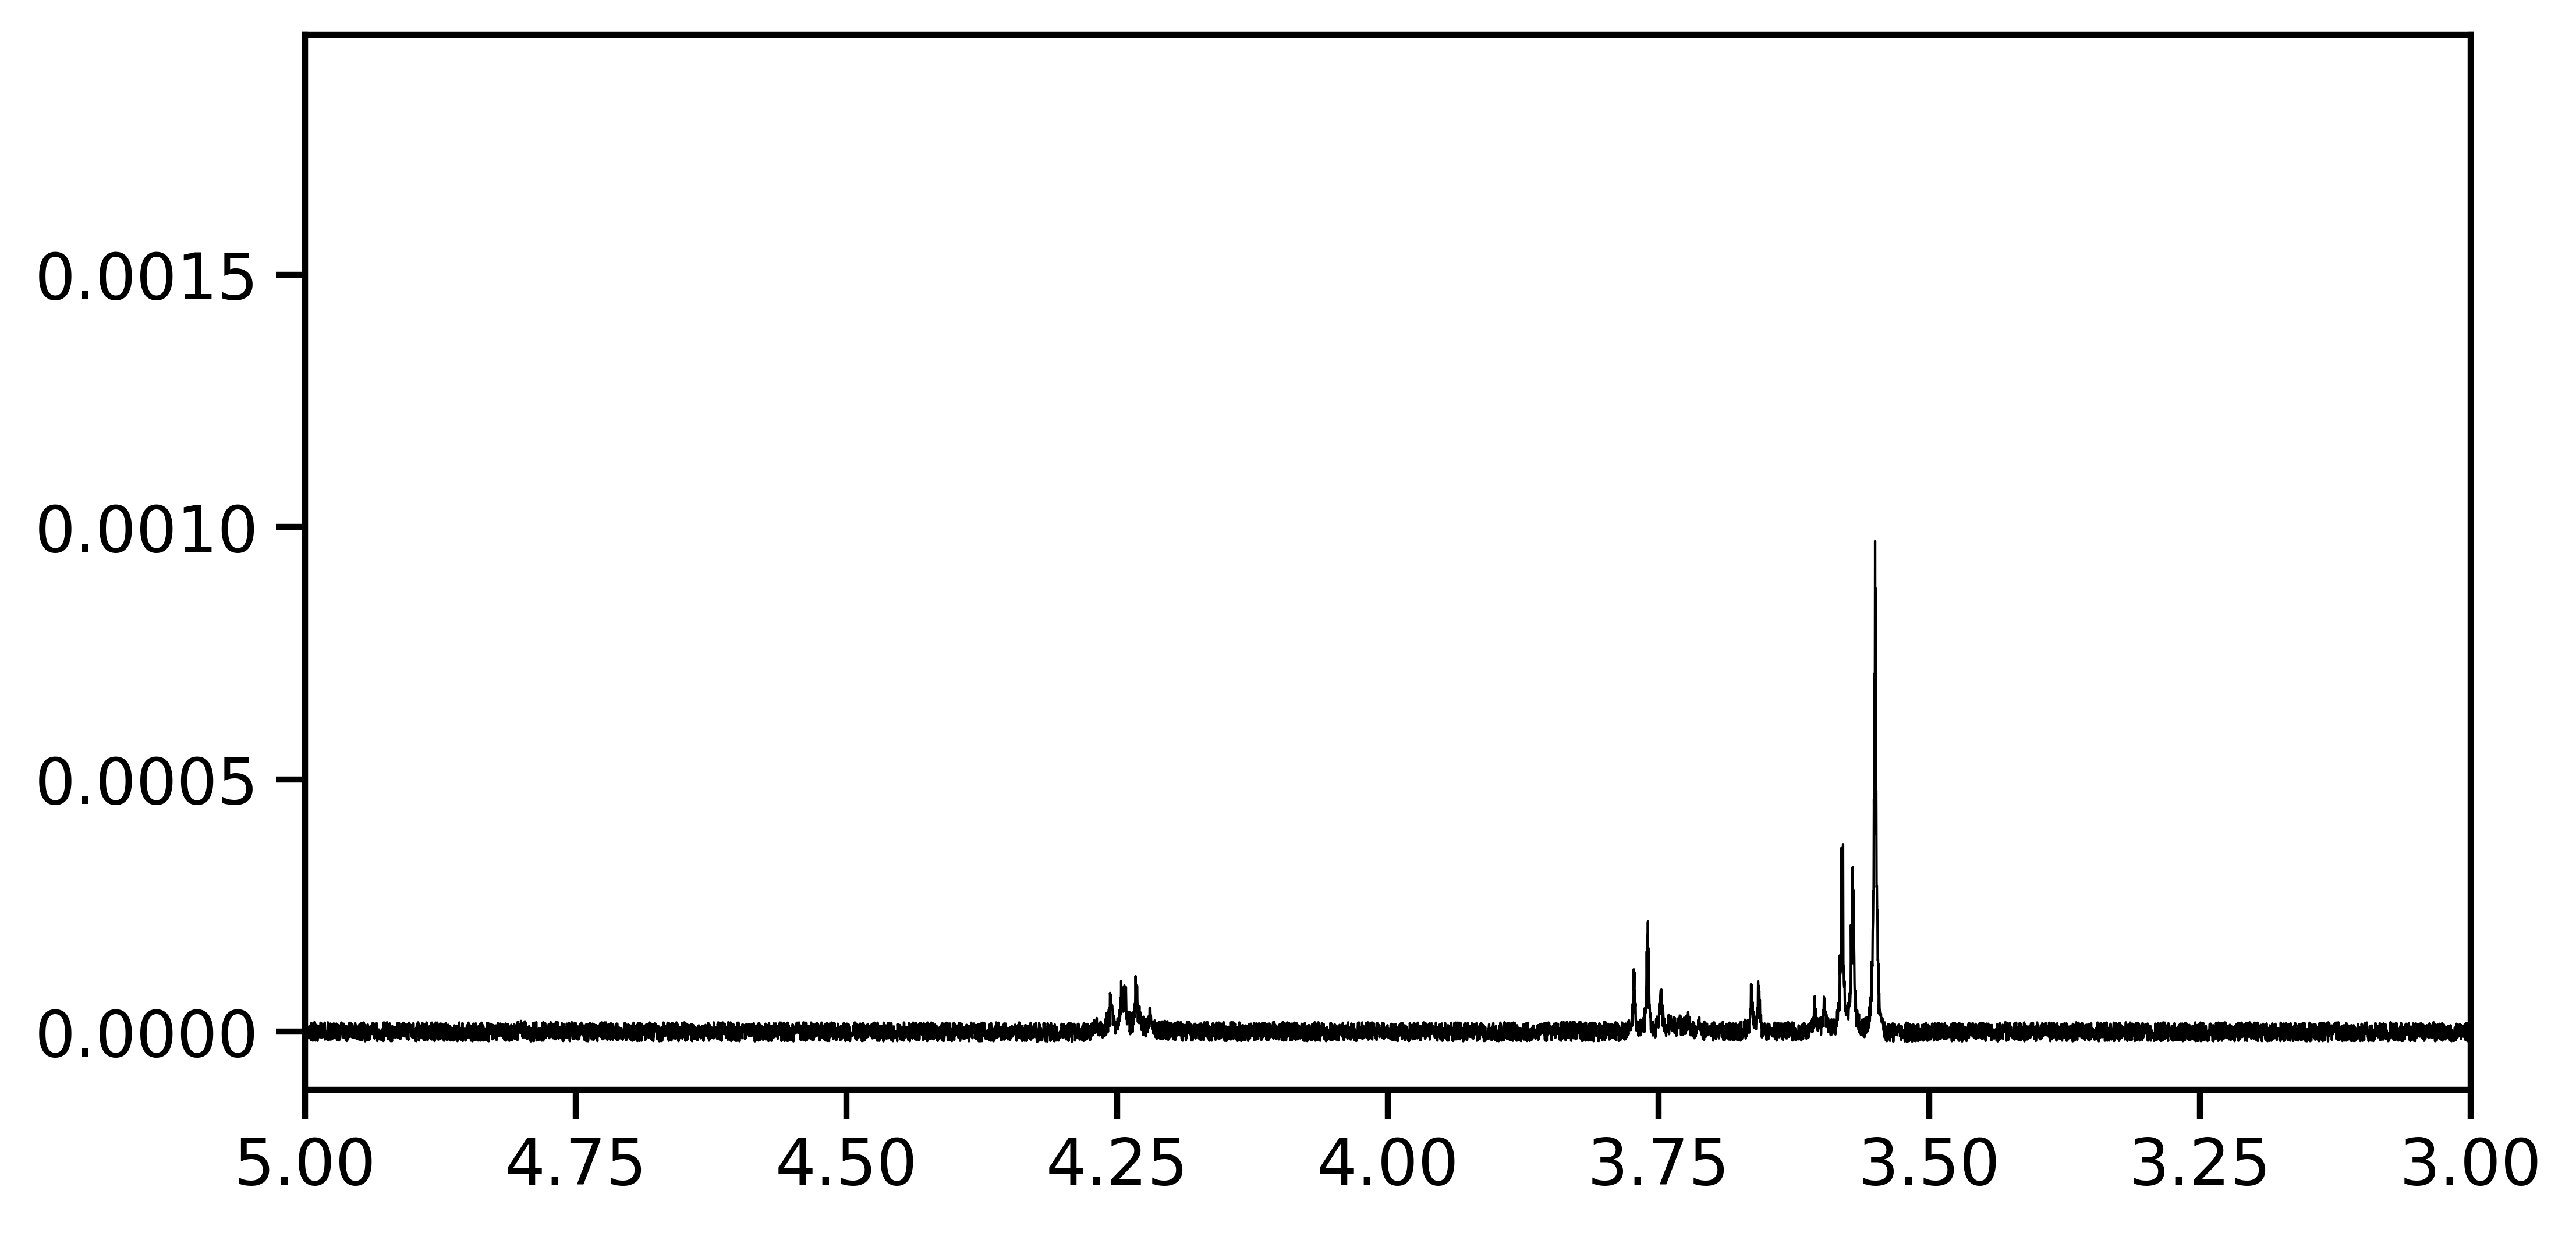

In [9]:
fig = plt.figure(figsize = (8, 4), dpi = 600) # change dpi to 1200
plt.plot(datm.ppm, datm_noisy.intensity, color = 'black', linewidth = 0.5)
plt.xlim([5.0, 3.0])
plt.show()